In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
%matplotlib inline

## Introduction
In this notebook I will be analyzing the counts and percentage of **disputed** customer complaints with regard to financial institutions, states and financial products along with a quick and dirty machine learning model to give a rough prediction of when the disputes will occur

### Importing and Cleaning Data

In [25]:
df = pd.read_csv('consumer_complaints.csv', parse_dates=['date_received', 'date_sent_to_company'], low_memory=False)
df.head()

,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,2013-08-30,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511074
1,2013-08-30,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,2013-09-03,Closed with explanation,Yes,Yes,511080
2,2013-08-30,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,2013-09-18,Closed with explanation,Yes,No,510473
3,2013-08-30,Student loan,Non-federal student loan,Repaying your loan,Repaying your loan,NaN,NaN,"Navient Solutions, Inc.",MD,21402,NaN,NaN,Email,2013-08-30,Closed with explanation,Yes,Yes,510326
4,2013-08-30,Debt collection,Credit card,False statements or representation,Attempted to collect wrong amount,NaN,NaN,Resurgent Capital Services L.P.,GA,30106,NaN,NaN,Web,2013-08-30,Closed with explanation,Yes,Yes,511067


Having a clean dataset allows for higher accuracy in visualizing, analyzing and in this case predicting on the dataset. In order to make the most efficient use of the above data, I am checking for the number of empty/NaN rows:

In [26]:
#Check NaNs
df.isna().sum()

date_received                        0
product                              0
sub_product                     158322
issue                                0
sub_issue                       343335
consumer_complaint_narrative    489151
company_public_response         470833
company                              0
state                             4887
zipcode                           4505
tags                            477998
consumer_consent_provided       432499
submitted_via                        0
date_sent_to_company                 0
company_response_to_consumer         0
timely_response                      0
consumer_disputed?                   0
complaint_id                         0
dtype: int64

From the above output it is evident that the dataset if populated with many NaNs. However, removing all NaN values can cause overfitting in the prediction model and inaccuracies in the data analysis.

So, keeping threshold of *column contains >= 10% NaNs* we will clean each column

In [27]:
thresh = 0.10
col_nans = df.isna().mean(axis=0)
col_w_thresh = col_nans[col_nans >= thresh]
col_w_thresh

sub_product                     0.284774
sub_issue                       0.617557
consumer_complaint_narrative    0.879836
company_public_response         0.846887
tags                            0.859775
consumer_consent_provided       0.777936
dtype: float64

The above columns will now be dropped as they have too many NaNs to have any use in our dataset. 
*NOTE:* Along with these, the *complaint_id* column will aso be dropped for not being relevant in our analysis

In [28]:
drops_l = list(col_w_thresh.index) + ['complaint_id']
df = df.drop(drops_l, axis=1)

#Tokenizing Yes and No to 1 and 0 respectively
df = df.replace(['Yes', 'No'], [1, 0])

df.loc[df['company_response_to_consumer'].str.contains("Closed"), 'company_response_to_consumer'] = 1
df.loc[df['company_response_to_consumer'] != 1, 'company_response_to_consumer'] = 0
df.head()

,date_received,product,issue,company,state,zipcode,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?
0,2013-08-30,Mortgage,"Loan modification,collection,foreclosure",U.S. Bancorp,CA,95993,Referral,2013-09-03,1,1,1
1,2013-08-30,Mortgage,"Loan servicing, payments, escrow account",Wells Fargo & Company,CA,91104,Referral,2013-09-03,1,1,1
2,2013-08-30,Credit reporting,Incorrect information on credit report,Wells Fargo & Company,NY,11764,Postal mail,2013-09-18,1,1,0
3,2013-08-30,Student loan,Repaying your loan,"Navient Solutions, Inc.",MD,21402,Email,2013-08-30,1,1,1
4,2013-08-30,Debt collection,False statements or representation,Resurgent Capital Services L.P.,GA,30106,Web,2013-08-30,1,1,1


### Data Analysis and Visualization
Since I will be mainly checking the count AND rate of disputed issues, the following functions will be used to get these metrics as a DataFrame:

In [49]:
#disp_cat = ""
def is_disputed(row, cat):
    return df[(df['consumer_disputed?'] == 1) & (df[cat] == row[cat])]['consumer_disputed?'].sum()

def get_count(cat, data=df):
    #disp_cat = cat
    df_by_cat = df[[cat, 'issue', 'consumer_disputed?']].groupby([cat]).count().reset_index()
    
    df_by_cat['consumer_disputed?'] = df_by_cat.apply(lambda r: is_disputed(r, cat), axis=1)
    
    df_by_cat['dispute_rate'] = df_by_cat.apply(lambda r: (r['consumer_disputed?'] / r['issue']) * 100, axis=1)
    
    return df_by_cat

In [58]:
#State with most disputes using above function:
disp_st = get_count('state')
st_c = disp_st['consumer_disputed?']
m_st = disp_st['state'][pd.Series.argmax(st_c)]
m_c = disp_st['consumer_disputed?'][pd.Series.argmax(st_c)]
print("State is", m_st, "with disputes:", m_c)

State is CA with disputes: 17615


<BarContainer object of 62 artists>

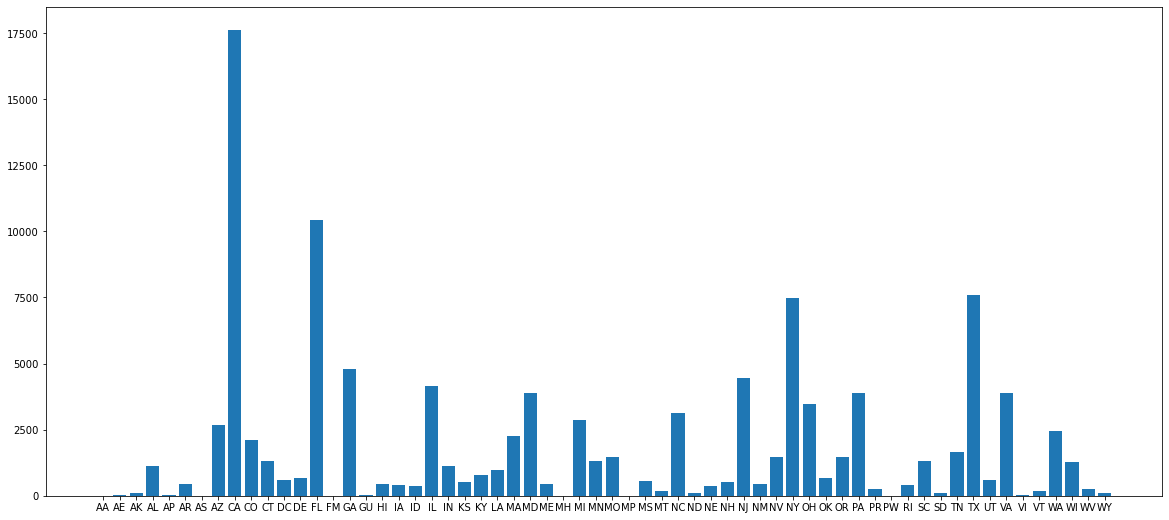

In [63]:
fig1, ax1 = plt.subplots(figsize=(20, 9))
ax1.bar(disp_st['state'], disp_st['consumer_disputed?'])

<BarContainer object of 62 artists>

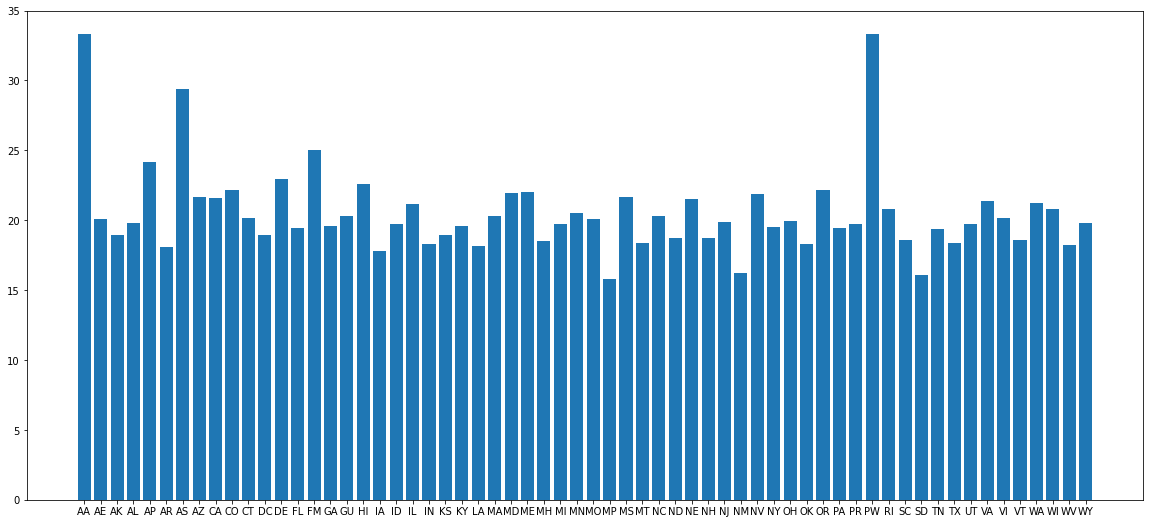

In [65]:
fig2, ax2 = plt.subplots(figsize=(20, 9))
ax2.bar(disp_st['state'], disp_st['dispute_rate'])

In [29]:
#Getting count of issues per state with products
state_issue_count = df.groupby(['state', 'product', 'issue']).size().reset_index()
state_issue_count.columns = ['state', 'product', 'issue','count']

In [9]:
#States with 5 highest dispute counts, issues and product
state_issue_count.sort_values(by = 'count', ascending = False).head()

,state,product,issue,count
501,CA,Mortgage,"Loan modification,collection,foreclosure",19433
942,FL,Mortgage,"Loan modification,collection,foreclosure",11337
502,CA,Mortgage,"Loan servicing, payments, escrow account",8957
4028,TX,Credit reporting,Incorrect information on credit report,8712
485,CA,Credit reporting,Incorrect information on credit report,8585


In [10]:
#States with 5 lowest dispute counts with related issues and products
state_issue_count.sort_values(by = 'count', ascending = False).tail()

,state,product,issue,count
3083,NV,Prepaid card,"Overdraft, savings or rewards features",1
347,AZ,Consumer Loan,Payment to acct not credited,1
344,AZ,Consumer Loan,Lender repossessed or sold the vehicle,1
1,AA,Credit card,Identity theft / Fraud / Embezzlement,1
0,AA,Bank account or service,"Account opening, closing, or management",1


**Analysis**: As the above console output and bar graphs show, states with higher populations such as CA, NY, TX etc tend to have more disputes over financial issues. Moreover, West Coast states have a higher tendency to dipute complaints. Laws regarding financial products and the companies headquartered in these states are areas which can be further analysed for why they yield such high issue counts

In [21]:
#Highest issues per product
product_issue_count = df.groupby(['product', 'issue']).size().reset_index()
product_issue_count.columns = ['product', 'issue', 'count']
product_issue_count.sort_values(by = 'count', ascending=False).head()

,product,issue,count
75,Mortgage,"Loan modification,collection,foreclosure",97191
59,Credit reporting,Incorrect information on credit report,66718
76,Mortgage,"Loan servicing, payments, escrow account",60375
62,Debt collection,Cont'd attempts collect debt not owed,42285
0,Bank account or service,"Account opening, closing, or management",26661


Text(0, 0.5, 'Product')

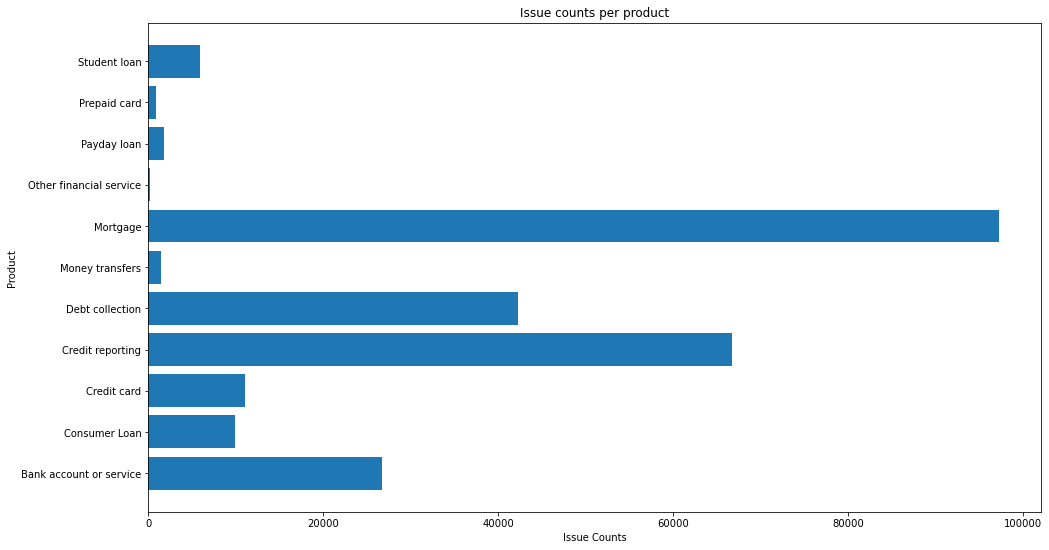

In [23]:
#BAR PLOT
fig3, ax3 = plt.subplots(figsize=(16, 9))
#prod_u, counts = np.unique(product_issue_count['product'].values, return_counts=True)
ax3.barh(product_issue_count['product'], product_issue_count['count'])
    
#ax2.set_title("Issue counts per product with (companies are bar colors)")
ax3.set_title("Issue counts per product")
ax3.set_xlabel('Issue Counts')
ax3.set_ylabel('Product')

In [24]:
#Banks' products with highest issues
bank_prod_count = df.groupby(['company', 'product', 'issue']).size().reset_index()
bank_prod_count

,company,product,issue,0
0,"(Former)Shapiro, Swertfeger & Hasty, LLP",Debt collection,Disclosure verification of debt,2
1,"(Former)Shapiro, Swertfeger & Hasty, LLP",Mortgage,"Loan modification,collection,foreclosure",1
2,"(Former)Shapiro, Swertfeger & Hasty, LLP",Mortgage,"Loan servicing, payments, escrow account",1
3,"1st 2nd Mortgage Company Of NJ, Inc.",Mortgage,"Application, originator, mortgage broker",1
4,1st Alliance Lending,Debt collection,Cont'd attempts collect debt not owed,1
...,...,...,...,...
18372,"iQuantified Management Services, LLC",Debt collection,Cont'd attempts collect debt not owed,1
18373,iServe Trust,Mortgage,Credit decision / Underwriting,1
18374,iServe Trust,Mortgage,"Loan modification,collection,foreclosure",4
18375,iServe Trust,Mortgage,"Loan servicing, payments, escrow account",1


In [134]:
#@TODO Common words in complaints

In [ ]:
#@TODO NLP prediction